### Goal

A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important
data scientist responsibility. Especially, data scientists have to make sure that results are
reliable, trustworthy, and conclusions can be drawn.
Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually
analyzing all of them would require lot of time and people. Therefore, it is common practice to
look at the typical A/B test analysis steps and try to automate as much as possible. This frees
up time for the data scientists to work on more high level topics.
In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to
design an algorithm to automate some steps.

---------
### Challenge Description

Your project is to:


- Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better.

- Explain why that might be happening. Are the localized translations really worse?

- If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

### Data

"test_table" - general information about the test results.
Columns:

- user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
- date : when they came to the site for the first time since the test started
- source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
- device : device used by the user. It can be mobile or web
- browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish)
- ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
- browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
- conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
- test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

"user_table" - some information about the user
Columns:

- user_id : the id of the user. It can be joined to user id in the other table
- sex : user sex: Male or Female
- age : user age (self-reported)
- country : user country based on ip address



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from IPython.display import display
from scipy.stats import ttest_ind


import warnings
warnings.filterwarnings('ignore')


C:\Users\user\Anaconda3\envs\ml_test\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\Anaconda3\envs\ml_test\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\user\Anaconda3\envs\ml_test\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
test = pd.read_csv('./data/test_table.csv')
user = pd.read_csv('./data/user_table.csv')


In [3]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1


In [4]:

test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [5]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:

user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [7]:

print('Variable', '      ', 'count of unique value','      ', 'content')
for column in test.columns:
    uniques = test[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:7])   

Variable        count of unique value        content
user_id              453321	 [315281 497851 848402 290051 548435 540675 863394]
date                    5	 ['12/3/2015' '12/4/2015' '11/30/2015' '12/1/2015' '12/2/2015']
source                  3	 ['Direct' 'Ads' 'SEO']
device                  2	 ['Web' 'Mobile']
browser_language        3	 ['ES' 'Other' 'EN']
ads_channel             6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
browser                 7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
conversion              2	 [1 0]
test                    2	 [0 1]


In [8]:
print('Variable', '       ', 'count of unique value','      ', 'content')
for column in user.columns:
    uniques = user[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:4]) 

Variable         count of unique value        content
user_id              452867	 [765821 343561 118744 987753]
sex                     2	 ['M' 'F']
age                    52	 [20 27 23 29]
country                17	 ['Mexico' 'Nicaragua' 'Colombia' 'Venezuela']


In [9]:

def Missing_Counts( Data, NoMissing=True ) : 
    missing = Data.isnull().sum()  
    
    if NoMissing==False :
        missing = missing[ missing>0 ]
        
    missing.sort_values( ascending=False, inplace=True )  
    Missing_Count = pd.DataFrame( { 'Column Name':missing.index, 'Missing Count':missing.values } ) 
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['Missing Count'].apply( lambda x: '{:.2%}'.format(x/Data.shape[0] ))
    return  Missing_Count



In [10]:
Missing_Counts(test)

,Column Name,Missing Count,Percentage(%)
0,ads_channel,271444,59.88%
1,test,0,0.00%
2,conversion,0,0.00%
3,browser,0,0.00%
4,browser_language,0,0.00%
5,device,0,0.00%
6,source,0,0.00%
7,date,0,0.00%
8,user_id,0,0.00%


In [11]:
Missing_Counts(user)

,Column Name,Missing Count,Percentage(%)
0,country,0,0.00%
1,age,0,0.00%
2,sex,0,0.00%
3,user_id,0,0.00%


In [12]:
#from pandas_profiling import ProfileReport
# 懶人包 可以測試
#plt.ion()
#profile = ProfileReport(data, title="Pandas Profiling Report")
#profile

In [13]:
# merge two tables
df = test.merge(user, how="left")
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


In [15]:
df.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


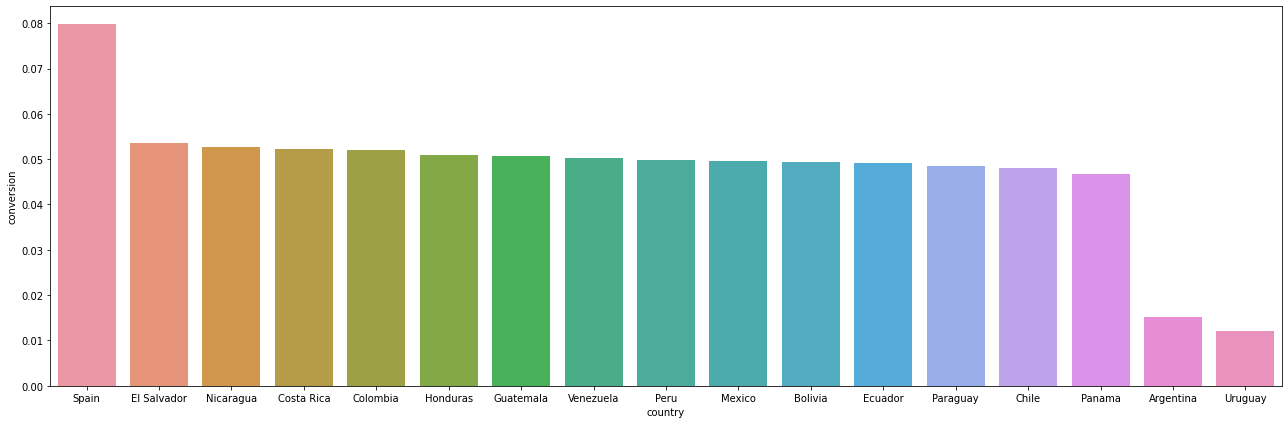

In [16]:
## Check if the spanish has high conversion rate

grouped_country = df[df['test']==0][['conversion','country']].groupby('country').mean().reset_index().sort_values('conversion',ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(x='country',y='conversion',data=grouped_country)
plt.tight_layout()
plt.show()


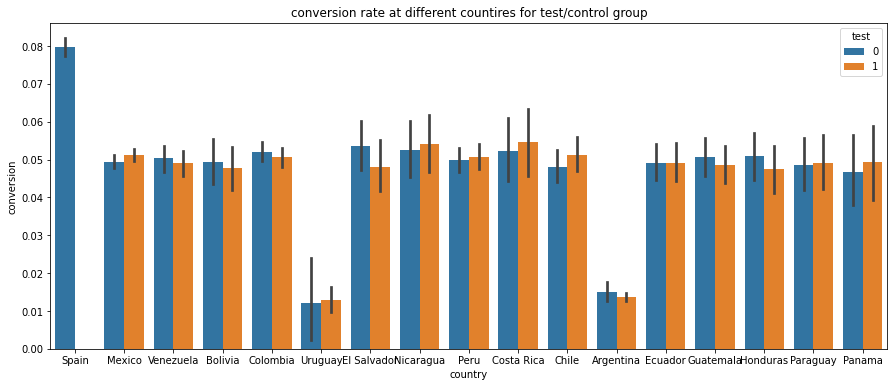

In [17]:
plt.subplots(1,1,figsize=(15,6))
sns.barplot(df['country'], df['conversion'], hue='test', data=df)
plt.title('conversion rate at different countires for test/control group')
plt.show()

In [18]:
## Confirm the test is negative by using t test.

# Determine dataset
data_goal = df[df['country']!='Spain']
control_data = data_goal[data_goal['test']==0]
test_data = data_goal[data_goal['test']==1]


In [19]:
print('Mean conversion rate of control group','\t' ,control_data['conversion'].values.mean())
print('Mean conversion rate of test group', '\t', test_data['conversion'].values.mean())

Mean conversion rate of control group 	 0.04833042316066309
Mean conversion rate of test group 	 0.043424713982118966


In [20]:
print(ttest_ind(control_data['conversion'].values, test_data['conversion'].values, equal_var = False))

Ttest_indResult(statistic=7.3939374121344805, pvalue=1.4282994754055316e-13)


--------------------



## Explain why that might be happening

In [21]:
## 參考 https://github.com/YZhu0225/Data_take_home_challenge/blob/main/02_Spanish%20Translation%20A-B%20Test.ipynb
def visualization(feature):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18, 6))
    sns.countplot(x = feature, hue='test', data = data_goal, ax = ax[0])
    ax[0].set_title('Count of {} in test/control group'.format(feature))

    sns.barplot(x = feature, y = 'conversion', hue='test', data = data_goal, ax = ax[1])
    ax[1].set_title('Conversion rate vs {} in test/control group'.format(feature))
    plt.show()


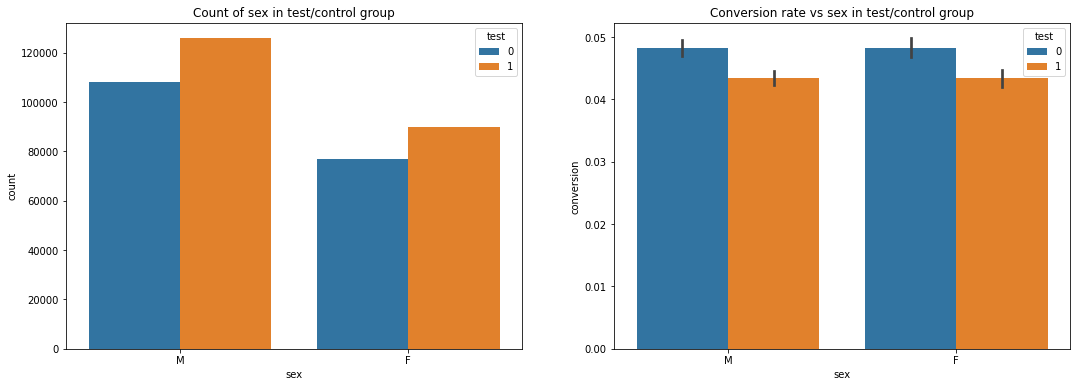

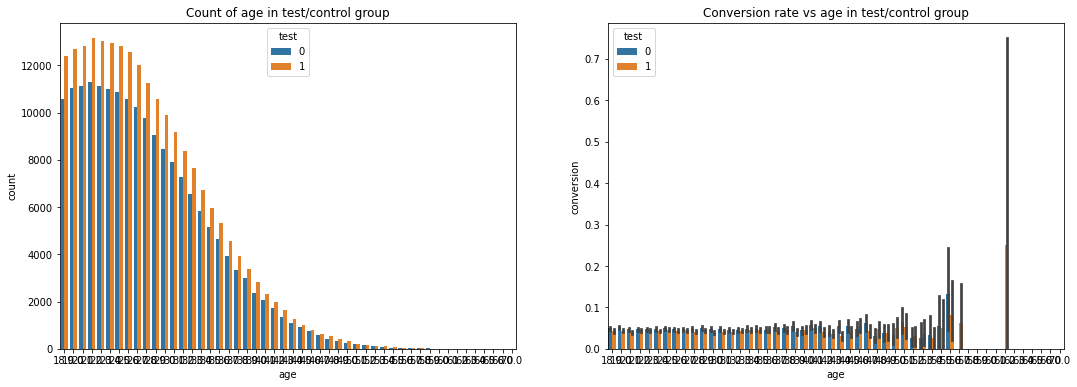

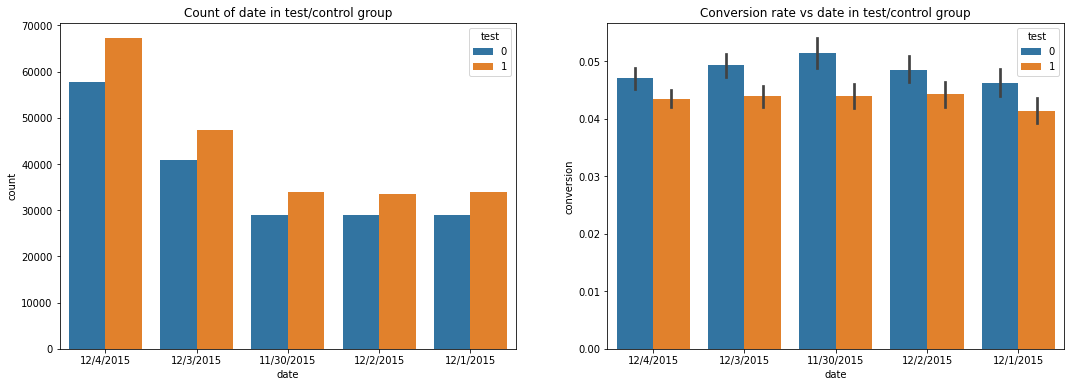

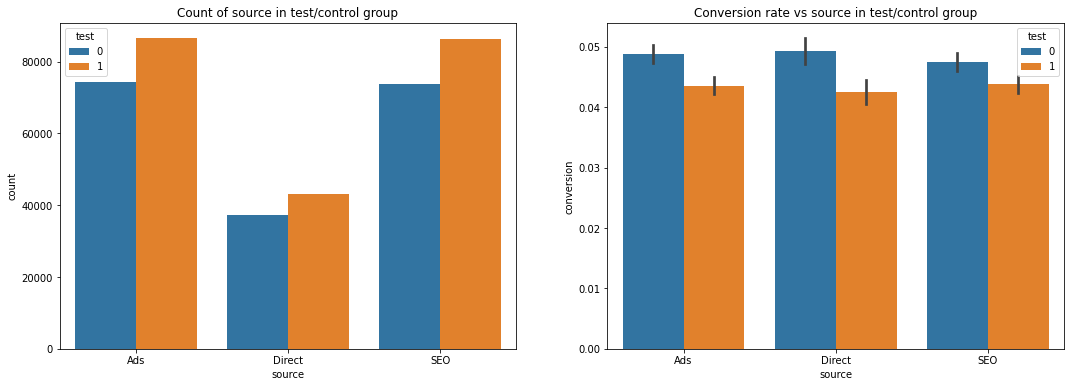

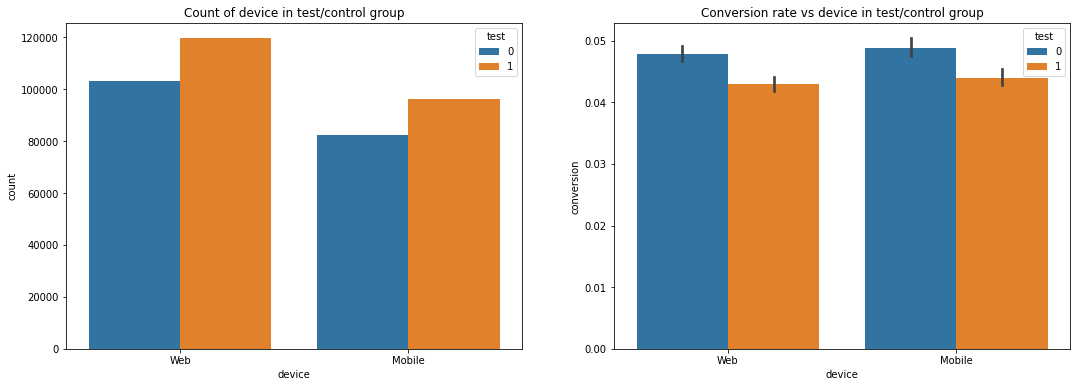

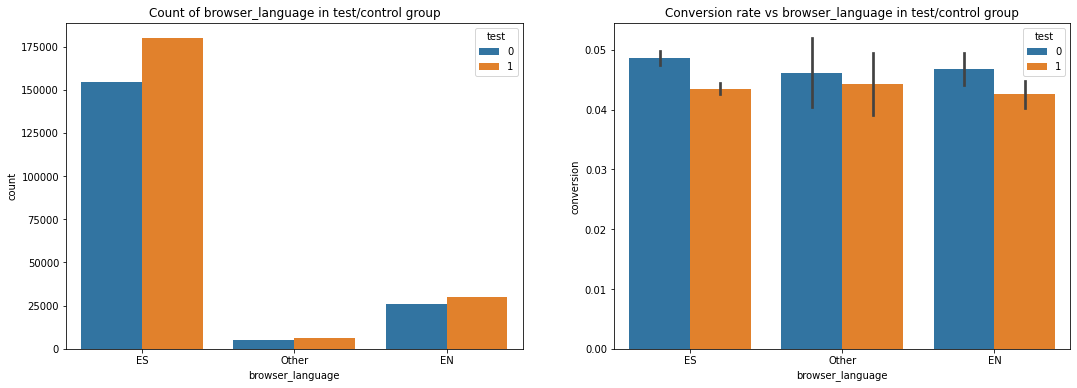

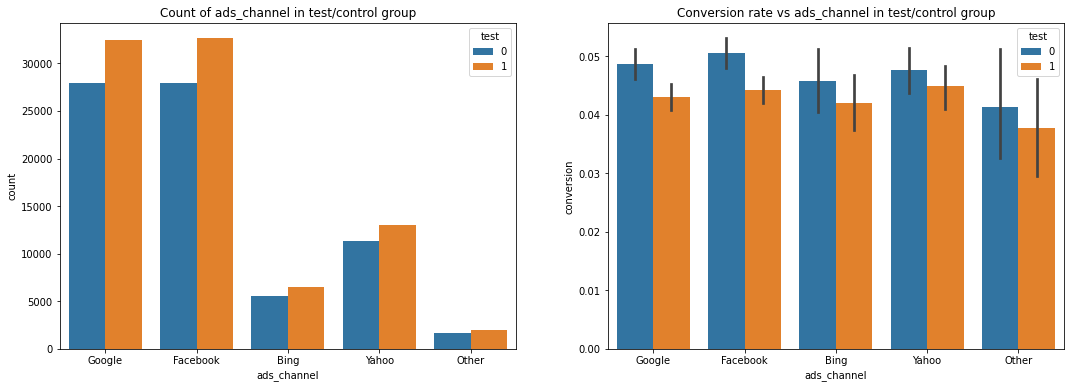

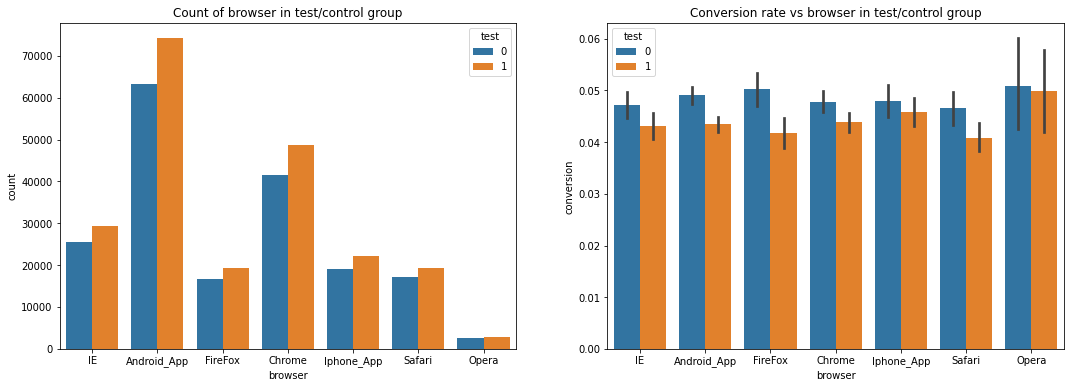

In [22]:
for i in ['sex','age','date','source','device','browser_language','ads_channel','browser']:
    visualization(i)


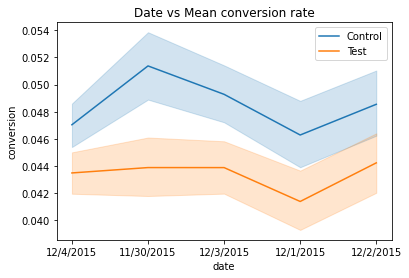

In [23]:

plt.subplots(1,1,figsize=(6,4))
plt.title('Date vs Mean conversion rate')
sns.lineplot(x='date',y='conversion',data=control_data,err_style='band',label='Control')
sns.lineplot(x='date',y='conversion',data=test_data,err_style='band',label='Test');
plt.legend();


For the date: 

1. The test has constantly been worse than the control and there is relatively little variance across days. 


2. We just ran it for 5 days. Maybe we should try to run the test  1 ~ 2 weeks .





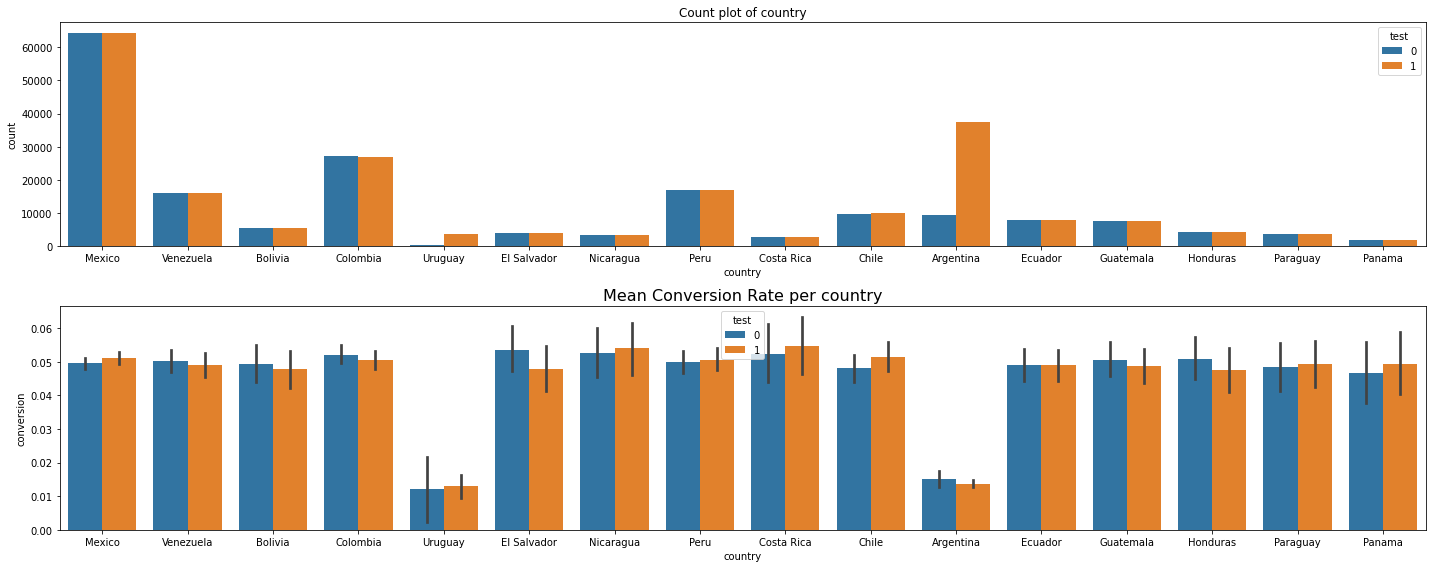

In [24]:
# Country variable visualization
fig, ax = plt.subplots(2,1,figsize=(20,8))
sns.countplot(data_goal['country'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of country',fontsize=12)

sns.barplot(x='country', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per country', fontsize=16)

plt.tight_layout()
plt.show()


In an ideal world, the distribution of people in test and control for each segment should be the same. But from the EDA section, I found that the number of control and test group in Argentina and Uruguary isn't equal to each other which is not acceptable since other countries all keep the 50/50 pattern. Let's check for each country.

In [25]:
print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.format('Country', 'Mean of Control', 'Mean of Test', 'P-Value', 'No.Control/No.Test'))
print('-' * 85)
p=[]
for country in data_goal['country'].dropna().unique():
    data_country = data_goal[data_goal['country']==country]
    cont_country = data_country[data_country['test']==0].conversion.values
    test_country = data_country[data_country['test']==1].conversion.values
    p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
    p.append(p_value)
    ratio = len(cont_country)/len(test_country)
    print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.format(country,cont_country.mean(),test_country.mean(),p_value,ratio))



Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

After we control for country, the test clearly appears not significant. Now we know that a localized translation does not result in conversion rate drop.

In [26]:
def sanitycheck(data,error):
    # no need to include users in Spain
    data = data[data['country']!='Spain']
    country_name = data['country'].dropna().unique()
    sig_country=[]
    print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.
          format('Country', 'Mean of Control','Mean of Test', 'P-Value', 'No.Control/No.Test'))
    print('-' * 85)
    # check each country
    for country in country_name:
        data_country = data[data['country']==country]
        # split into control and test group
        cont_country = data_country[data_country['test']==0].conversion.values
        test_country = data_country[data_country['test']==1].conversion.values
        p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
        if p_value < error:
            sig_country.append(country)
        ratio = len(cont_country)/len(test_country)
        print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.
              format(country,cont_country.mean(),test_country.mean(),p_value,ratio))
    if len(sig_country)==len(country_name):
        print('Everything is good and the result can be trusted!')
        return('TRUE')
    else:
        print('There is at least something wrong among one of countries, its result is not significant. Please check.' )
        return('FALSE')



In [27]:

sanitycheck(data_goal,0.05)

Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

'FALSE'